# Instagram Analysis
Koosha Zarei

Telecom SudParis - September 2018

Libraries:
    - pymongo
    - json
    - re
    - landgetect
    - twitter
    - pd
    - instaloader
    - matplotlib
    - pylab
    
Note:
    first you have to use crawler to capture some data from instagram, and then put the file name here

Instagram is a social media platform for sharing visual media and has become one of the top social networks in recent years. According to Statista, the mainly mobile sharing network, is one of the most popular social networks worldwide and had reached 1 million active users monthly. As a result, it causes advertisement and spam post flooding. The value of detecting and decreasing spams and fake posts are of high importance. In such a scenario, the analysis of comment becomes important for detecting the unusual behaviors and bot patterns.

Comment Json Structure:

    "id": 17971677547123467,
    "created_at": 1539866824,
    "text": "xxxxxxx",
    "owner": {
        "id": "1111111",
        "profile_pic_url": "url",
        "username": "leighblantaco"
    }


In [1]:
#Import all libraries that are required
%matplotlib inline

import numpy as np
import pandas as pd
# pd.options.display.float_formatrmat = '${:,.2f}'.format
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

from io import BytesIO
from requests import get
from PIL import Image, ImageDraw
import instaloader
import pymongo

from pandas.io.json import json_normalize
import json

#NECESSARY FOR XTICKS OPTION, ETC.
from pylab import*
from itertools import dropwhile, takewhile
import collections

from pandas.tools.plotting import scatter_matrix

## Parameters

In [2]:
# create loader object
L = instaloader.Instaloader()

#Set PANDAS to show all columns in DataFrame
# pd.set_option('display.max_columns', None)
# plt.rcParams['figure.figsize'] = (15, 5)

UTC_FILE_NAME = "_UTC"
COMMENTS_FILE_NAME = "_comments"
FILE_ADDRESS_NAME = "InstagramLog/"


DONALD_TRUMP = 'realdonaldtrump'
DONALD_TRUMP_NAME = 'President Donald J. Trump'
DONALD_TRUMP_BIO = '45th President of the United States'

BARAK_OBAMA = 'barackobama'
BARACK_OBAMA_NAME = 'Barack Obama'
BARACK_OBAMA_BIO = 'Dad, husband, President, citizen.'

EMMANUEL_MACRON = 'emmanuelmacron'
EMMANUEL_MACRON_NAME = 'Emmanuel Macron'
EMMANUEL_MACRON_BIO = 'Président de la République française.'

USER_ACCOUNT = EMMANUEL_MACRON
USER_ACCOUNT_NAME = EMMANUEL_MACRON_NAME
USER_ACCOUNT_BIO = EMMANUEL_MACRON_BIO

# MongoDB Database
instagramClient = pymongo.MongoClient('157.159.68.107:27017',username='koosha',password='1123581321',authSource='Instagram')
instagram_db = instagramClient["Instagram"]
instagram_col_post = instagram_db["Post"]
instagram_col_comment = instagram_db["Comment"]
instagram_col_like = instagram_db["Like"]
instagram_col_analyse = instagram_db["Analyse"]
instagram_col_mentioned_in_comment = instagram_db["MentionedInComment"]


# Functions

In [3]:
def percentage(percent, whole):
    return (percent * whole) / 100.0

def percentage_part(part, whole):
    return 100 * float(part)/float(whole)

In [4]:
def difflib_compare():
    import difflib

    a = 'trump_for_ever'
    b = 'trump'

    seq = difflib.SequenceMatcher(None,a,b)
    d = seq.ratio()*100
    print(d) 


In [5]:
def text_similarity(_text1, _text2):
    
    import nltk, string
    from sklearn.feature_extraction.text import TfidfVectorizer

#     nltk.download('punkt') # if necessary...

    stemmer = nltk.stem.porter.PorterStemmer()
    # remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)
    # translator = str.maketrans(' ', ' ', string.punctuation)
    translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))

    def stem_tokens(tokens):
        return [stemmer.stem(item) for item in tokens]

    '''remove punctuation, lowercase, stem'''
    def normalize(text):
        return stem_tokens(nltk.word_tokenize(text.lower().translate(translator)))


    vectorizer = TfidfVectorizer(tokenizer=normalize, stop_words='english')

    def cosine_sim(text1, text2):
        tfidf = vectorizer.fit_transform([text1, text2])
        return ((tfidf * tfidf.T).A)[0,1]
    
    list_export= []
    for item in _text2:
        list_export.append(cosine_sim(item, _text1))

    return max(list_export)

In [6]:
from sklearn.cluster import KMeans

merged_Frame = pd.DataFrame()

def calculate_common_user():
    list_of_unique_user_id_per_comment = list(instagram_col_comment.aggregate([

        { '$match':
         { 
             '$and': [
                 { 'shortcode_username': USER_ACCOUNT },
             ]
         }
        },

        {'$group':   {
            "_id": "$owener_id",
            "totalComment" : {"$sum" : 1},
            "post_ids_c" : {"$addToSet" : "$post_shortcode"},
            "post_texts": {"$addToSet" : "$text"},
            'followers_c' : { '$first': '$owener_followers' },
            'followees_c' : { '$first': '$owener_followees' },
            'mediacount_c' : { '$first': '$owener_mediacount' },
            'biography_c' : { '$first': '$owener_biography' },
            'username_c' : { '$first': '$owener_username' },
            'is_verified_c' : { '$first': '$owener_is_verified' },
            'full_name_c' : { '$first': '$owener_full_name' },
            'is_private_c' : { '$first': '$owener_is_private' },
            }
        },

    ]))


    data_comment =  pd.DataFrame(list_of_unique_user_id_per_comment)
    total_users_comment = data_comment.shape[0]
    print( "Total User (Comment): " + str(total_users_comment))
    data_comment['Total_post (c)'] = data_comment['post_ids_c'].str.len()

#     df_comment = data_comment[['_id', 'username', 'totalComment', 'Total_post (c)', 'followers_c', 'followees_c', 'mediacount_c']]

    
    list_comment_ids = data_comment['_id']
#     grouped_comment = df_comment.groupby('Total_post (c)')
#     list_keys_comment = list(grouped_comment.groups.keys())
#     df_grouped_comment = pd.DataFrame({'count (c)' : grouped_comment.size()}).reset_index()
#     df_grouped_comment.set_index('Total_post (c)')
#     print(df_grouped_comment)
    
    
    
    
    #======= like ============
    list_of_unique_user_id_per_like = list(instagram_col_like.aggregate(pipeline=[
        
        { '$match':
         { 
             '$and': [
                 { 'shortcode_username': USER_ACCOUNT },
             ]
         }
        },

        {'$group':   {
            "_id": "$owener_id",
            "totalLike" : {"$sum" : 1},
            "post_ids_l" : {"$addToSet" : "$post_shortcode"},
            'followers_l' : { '$first': '$owener_followers' },
            'followees_l' : { '$first': '$owener_followees' },
            'mediacount_l' : { '$first': '$owener_mediacount' },
            'biography_l' : { '$first': '$owener_biography' },
            'username_l' : { '$first': '$owener_username' },
            'is_verified_l' : { '$first': '$owener_is_verified' },
            'full_name_l' : { '$first': '$owener_full_name' },
            'is_private_l' : { '$first': '$owener_is_private' },
            }
        },

    ],
        allowDiskUse=True
    ))
    

    data_like =  pd.DataFrame(list_of_unique_user_id_per_like)
    total_users_like = data_like.shape[0]
    print( "Total User (Like): " + str(total_users_like))
    data_like['Total_post (l)'] = data_like['post_ids_l'].str.len()

    list_like_ids = data_like['_id']
    
#     df_like = data_like[['_id', 'username', 'totalLike', 'Total_post (l)', 'followers_l', 'followees_l', 'mediacount_l']]

    
    global merged_Frame
    
    # merge
    merged_Frame = pd.merge(data_like, data_comment, on ="_id")
    merged_Frame.replace("", np.nan, inplace=True)
    
    total_unique_users = len( list(set(list_like_ids)|set(list_comment_ids)) )
    
    percentage_common = (100 * merged_Frame.shape[0]) / total_unique_users
    
    print("Total unique user: ", str(total_unique_users) )
    print("Total User in common (Like & Comment): " +  "{:,.2f}".format(percentage_common) + "% | " + str(merged_Frame.shape[0]))
#     print(merged_Frame.head(10))
    
    
#     kmeans = KMeans(n_clusters=2, random_state=0)
#     kmeans.fit(merged_Frame[['Total_post (c)','Total_post (l)']])
#     y_kmeans = kmeans.predict(merged_Frame[['Total_post (c)','Total_post (l)']])
    
#     fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,4))
    
calculate_common_user()

Total User (Comment): 19976
Total User (Like): 332530
Total unique user:  342471
Total User in common (Like & Comment): 2.93% | 10035


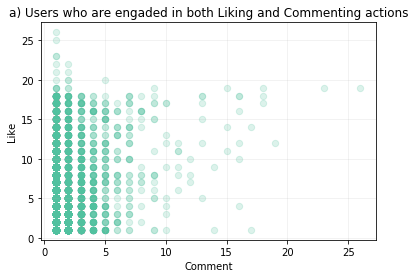

In [7]:
def plot_1():
    
    global merged_Frame
    
    # scatter
    ax = merged_Frame.plot.scatter(x='Total_post (c)', y='Total_post (l)', c='#51c19f', alpha=0.2, logy=False, grid=True, s=40)
    ax.grid(True, which='both', linestyle='-', alpha=0.2)
    ax.set_ylabel("Like")
    ax.set_xlabel("Comment")
    ax.set_title("a) Users who are engaded in both Liking and Commenting actions")
    
    
#     ax2 = merged_Frame.plot.scatter(x='Total_post (c)', y='Total_post (l)', c=y_kmeans, ax=ax2, grid=True, s=30)
#     ax2.grid(True, which='both', linestyle='-', alpha=0.2)
#     ax2.set_ylabel("Like")
#     ax2.set_xlabel("Comment")
#     ax2.set_title("a)")
#     plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis', ax=ax2 )
    
    # group
#     grouped_all = merged_Frame.groupby('totalComment_x')
#     list_keys_all = list(grouped_all.groups.keys())
#     print(list_keys_all)
#     print(grouped_all.get_group(list_keys_all[-1]))

plot_1()

For the next step, we obtained those users who are engaged in both commenting and liking actions. This group includes around 4% of the total unique profile account. So with regarding unique users and amount of posts,  figure a) illustrates scatter plot of the portion of like vs. comment of these users.

The density of dots in like axis is stronger than comment axis and around 75% of the posts received like. Generally, it could be remarked that the desire for liking is more than commenting. On the other hand, there are some users who prefer to do commenting as it can be observed in the right part of the figure.

In [8]:
global merged_Frame

# merged_Frame.replace("", np.nan, inplace=True)
# print(merged_Frame.head(5))

merged_Frame['combined_follower'] = merged_Frame.apply(lambda r:  r["followers_c"] if r["followers_c"] != np.nan else r["followers_l"], axis=1)
merged_Frame['combined_followee'] = merged_Frame.apply(lambda r:  r["followees_c"] if r["followees_c"] != np.nan else r["followees_l"], axis=1)
merged_Frame['combined_mediacount'] = merged_Frame.apply(lambda r:  r["mediacount_c"] if r["mediacount_c"] != np.nan else r["mediacount_l"], axis=1)
merged_Frame['combined_is_verified'] = merged_Frame.apply(lambda r:  r["is_verified_c"] if r["is_verified_c"] != np.nan else r["is_verified_l"], axis=1)
merged_Frame['combined_is_private'] = merged_Frame.apply(lambda r:  r["is_private_c"] if r["is_private_c"] != np.nan else r["is_private_l"], axis=1)
merged_Frame['combined_full_name'] = merged_Frame.apply(lambda r:  r["full_name_c"] if r["full_name_c"] != np.nan else r["full_name_l"], axis=1)
merged_Frame['combined_biography'] = merged_Frame.apply(lambda r:  r["biography_c"] if r["biography_c"] != np.nan else r["biography_l"], axis=1)
merged_Frame['combined_username'] = merged_Frame.apply(lambda r:  r["username_c"] if r["username_c"] != np.nan else r["username_l"], axis=1)

# print(merged_Frame.head(1))
# print(merged_Frame[['combined_is_verified', 'combined_is_private', 'combined_full_name', 'combined_biography' ]])

In [9]:
def analyze_similarity(dframe):

    merged_Frame = dframe
        
    merged_Frame.fillna("-", inplace=True)
    print("total: " + str(merged_Frame.shape[0]))

    if (not merged_Frame.empty):
        df_is_private = pd.DataFrame(merged_Frame['combined_is_private'].value_counts())
        percentage_of_private_user = (100 * df_is_private['combined_is_private'][1] ) / merged_Frame['combined_is_private'].count()
        percentage_of_public_user = (100 * df_is_private['combined_is_private'][0] ) / merged_Frame['combined_is_private'].count()


        df_is_verified = pd.DataFrame(merged_Frame['combined_is_verified'].value_counts())
        percentage_of_unverified_user = (100 * df_is_verified['combined_is_verified'][0] ) / merged_Frame['combined_is_verified'].count()
        percentage_of_verified_user = (100 * df_is_verified['combined_is_verified'][1] ) / merged_Frame['combined_is_verified'].count()#100 - percentage_of_unverified_user


        # process similarity
        TRUMP_DETAIL = [USER_ACCOUNT, USER_ACCOUNT_NAME, USER_ACCOUNT_BIO]
    #     df_temp = df_100[['owener_username', 'owener_full_name', 'owener_biography']].copy()


        merged_Frame['similarity_username'] = merged_Frame['combined_username'].apply(lambda x: text_similarity(x, TRUMP_DETAIL))
        merged_Frame['similarity_full_name'] = merged_Frame['combined_full_name'].apply(lambda x: text_similarity(x, TRUMP_DETAIL))
        merged_Frame['similarity_biography'] = merged_Frame['combined_biography'].apply(lambda x: text_similarity(x, TRUMP_DETAIL))
        merged_Frame['similar_total'] = merged_Frame['similarity_username'] + merged_Frame['similarity_full_name'] + merged_Frame['similarity_biography']


        # username similarity
        percentage_of_similar_username = (100 * (merged_Frame['similarity_username'] > 0).sum() ) / merged_Frame['similarity_username'].count()
        percentage_of_unsimilar_username = 100 - percentage_of_similar_username

        # full name similarity
        percentage_of_similar_fullname = (100 * (merged_Frame['similarity_full_name'] > 0).sum() ) / merged_Frame['similarity_full_name'].count()
        percentage_of_unsimilar_fullname = 100 - percentage_of_similar_fullname

        # bio similarity
        percentage_of_similar_bio = (100 * (merged_Frame['similarity_biography'] > 0).sum() ) / merged_Frame['similarity_biography'].count()
        percentage_of_unsimilar_bio = 100 - percentage_of_similar_bio

        # total similarity
        percentage_of_similar_total = (100 * (merged_Frame['similar_total'] > 0).sum() ) / merged_Frame['similar_total'].count()
        percentage_of_unsimilar_total = 100 - percentage_of_similar_total


    #         print(df_100)

        # create dataframe
        d = []    

        d.append(["Total User", "{:,}".format(merged_Frame.shape[0]) , '-'])
        d.append(["-", "-" , "-"])


        d.append(["Private user", "{:,.2f}".format(percentage_of_private_user) , df_is_private['combined_is_private'][1]])
        d.append(["Public user", "{:,.2f}".format(percentage_of_public_user), df_is_private['combined_is_private'][0]])
        d.append(["-", "-" , "-"])


        d.append(["Unverified User", "{:,.2f}".format(percentage_of_unverified_user) , df_is_verified['combined_is_verified'][0]])
        d.append(["verified User", "{:,.2f}".format(percentage_of_verified_user), df_is_verified['combined_is_verified'][1]])
        d.append(["-", "-" , "-"])


        d.append(["Similar Username", "{:,.2f}".format(percentage_of_similar_username) , (merged_Frame['similarity_username'] > 0).sum()])
        d.append(["Unsimilar Username", "{:,.2f}".format(percentage_of_unsimilar_username), merged_Frame['similarity_username'].count() - (merged_Frame['similarity_username'] > 0).sum()])
        d.append(["-", "-" , "-"])


        d.append(["Similar Full Name", "{:,.2f}".format(percentage_of_similar_fullname) , (merged_Frame['similarity_full_name'] > 0).sum()])
        d.append(["Unsimilar Full Name", "{:,.2f}".format(percentage_of_unsimilar_fullname), merged_Frame['similarity_full_name'].count() - (merged_Frame['similarity_full_name'] > 0).sum()])
        d.append(["-", "-" , "-"])


        d.append(["Similar Bio", "{:,.2f}".format(percentage_of_similar_bio) , (merged_Frame['similarity_biography'] > 0).sum()])
        d.append(["Unsimilar Bio", "{:,.2f}".format(percentage_of_unsimilar_bio), merged_Frame['similarity_biography'].count() - (merged_Frame['similarity_biography'] > 0).sum()])
        d.append(["-", "-" , "-"])


        d.append(["Similar User (Total)", "{:,.2f}".format(percentage_of_similar_total) , (merged_Frame['similar_total'] > 0).sum()])
        d.append(["Unsimilar User (Total)", "{:,.2f}".format(percentage_of_unsimilar_total), merged_Frame['similar_total'].count() - (merged_Frame['similar_total'] > 0).sum()])
        d.append(["-", "-" , "-"])


        df = pd.DataFrame(d, columns=["Name", "Percentage", "Numeric"])
        df = df.set_index(['Name'])

        return df


global merged_Frame
#     print(df_100)


analyze_similarity(merged_Frame)#.loc[:1000])



total: 10035


Percentage Numeric
Name                                     
Total User                 10,035       -
-                               -       -
Private user                23.82    2390
Public user                 27.70    2780
-                               -       -
Unverified User             51.46    5164
verified User                0.06       6
-                               -       -
Similar Username             0.19      19
Unsimilar Username          99.81   10016
-                               -       -
Similar Full Name            0.32      32
Unsimilar Full Name         99.68   10003
-                               -       -
Similar Bio                  2.39     240
Unsimilar Bio               97.61    9795
-                               -       -
Similar User (Total)         2.80     281
Unsimilar User (Total)      97.20    9754
-                               -       -

In [15]:
global merged_Frame

print(merged_Frame.columns)
print(merged_Frame.shape[0])

Index(['_id', 'biography_l', 'followees_l', 'followers_l', 'full_name_l',
       'is_private_l', 'is_verified_l', 'mediacount_l', 'post_ids_l',
       'totalLike', 'username_l', 'Total_post (l)', 'biography_c',
       'followees_c', 'followers_c', 'full_name_c', 'is_private_c',
       'is_verified_c', 'mediacount_c', 'post_ids_c', 'post_texts',
       'totalComment', 'username_c', 'Total_post (c)', 'combined_follower',
       'combined_followee', 'combined_mediacount', 'combined_is_verified',
       'combined_is_private', 'combined_full_name', 'combined_biography',
       'combined_username', 'similarity_username', 'similarity_full_name',
       'similarity_biography', 'similar_total'],
      dtype='object')
10035


In [11]:
global merged_Frame

def group_1_verified():


    merged_grouped_verified = merged_Frame.groupby('combined_is_verified')

    list_keys = list(merged_grouped_verified.groups.keys())
#     print(list_keys)
    print(merged_grouped_verified.get_group(list_keys[1]).shape[0])

    
group_1_verified()

6


In [12]:
global merged_Frame

def group_2_Smilar():

    merged_grouped_verified = merged_Frame[merged_Frame['similar_total'] > 0]

    print(merged_grouped_verified.shape[0])
#     print(merged_grouped_verified[['combined_username', 'combined_full_name', 'combined_biography']])
#     print(merged_grouped_verified.get_group(list_keys[1]))

    
group_2_Smilar()

281


In [13]:
global merged_Frame

def group_3_public_famous():
    global merged_Frame
    
    FAMOUS_USER = 500 * 1000
    SEMI_FAMOUS_USER = 100 * 1000
    
    
    merged_Frame['combined_follower'] = merged_Frame['combined_follower'].replace("-", 0)
    merged_Frame['combined_followee'] = merged_Frame['combined_followee'].replace("-", 0)
    merged_Frame['combined_mediacount'] = merged_Frame['combined_mediacount'].replace("-", 0)

    merged_grouped_verified = merged_Frame[merged_Frame['combined_follower'] > SEMI_FAMOUS_USER]
    print(merged_grouped_verified[['combined_follower', 'combined_followee']].shape[0])


    
group_3_public_famous()

12


11
      Total_post (c)                                         post_ids_c
2618              15  [Bq4wJznHA4n, Bq-ojqBHW7J, BrYiwuHHhxm, Bq2xuq...
6708              15  [Bq4wJznHA4n, Bq-ojqBHW7J, BodtJJ7l4N7, BoeFpv...
5277              16  [Bq4wJznHA4n, Bq-ojqBHW7J, BrYiwuHHhxm, BoyTm7...
5092              16  [Bq2xuqTH2aN, Bq4wJznHA4n, Bq-ojqBHW7J, BofAY2...
9020              16  [BrYiwuHHhxm, BoeFpvCF6CG, Bq-ojqBHW7J, BodtJJ...
1829              17  [Bq2xuqTH2aN, Bq4wJznHA4n, Bq-ojqBHW7J, BrYiwu...
8999              18  [Bq2xuqTH2aN, Bq4wJznHA4n, BrYiwuHHhxm, Bq-ojq...
8060              18  [Bq4wJznHA4n, BrYiwuHHhxm, Bq-ojqBHW7J, BodtJJ...
9904              18  [Bq4wJznHA4n, Bq-ojqBHW7J, BrYiwuHHhxm, BpzPeI...
3225              23  [BqUv1eonVJQ, BqZNKXGHZO6, BqeiARDHGbq, BqmwKy...
5360              26  [Bq4wJznHA4n, BqUv1eonVJQ, BqZNKXGHZO6, BqeiAR...


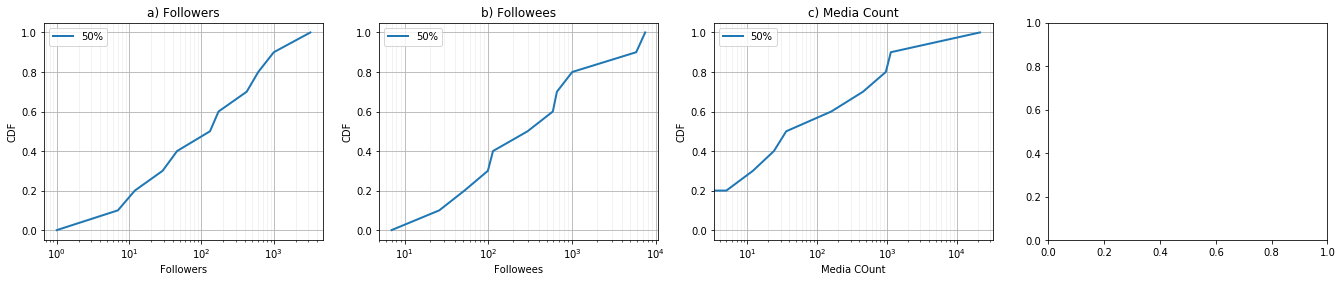

In [14]:
global merged_Frame

def group_4_most_50p_active_user():
    global merged_Frame
    
    merged_Frame_grouped = merged_Frame.groupby('Total_post (l)')
    list_keys = list(merged_Frame_grouped.groups.keys())
    
    percent_75 = percentage(75, list_keys[-1])
    percent_50 = percentage(50, list_keys[-1])
    percent_25 = percentage(25, list_keys[-1])
    
#     print(merged_Frame_grouped)

#     df_grouped = pd.DataFrame({'count' : merged_Frame_grouped.size()}).reset_index()
#     df_grouped['Group'] = "G1"    
#     print(df_grouped)

    list_100 = [x for x in list_keys if x > percent_50]
    
    l_tmp = []
    for i in list_100:
        l_tmp.append(list_keys.index(i))
    
    df_100 = pd.DataFrame()
    
    for item in l_tmp:
        df_tmp = pd.DataFrame(merged_Frame_grouped.get_group(list_keys[item]))
        df_100 = pd.concat([df_100, df_tmp])
    
    
    merged_Frame_grouped_second = df_100.groupby('Total_post (c)')
    list_keys_second = list(merged_Frame_grouped_second.groups.keys())
    
#     print(list_keys_second)
    
    percent_75_second = percentage(75, list_keys_second[-1])
    percent_50_second = percentage(50, list_keys_second[-1])
        
        
    list_100_second = [x for x in list_keys_second if x > percent_50_second]
    
#     print(list_100_second)
    l_tmp_second = []
    for i in list_100_second:
        l_tmp_second.append(list_keys_second.index(i))
    
    df_100_second = pd.DataFrame()
    
    for item in l_tmp_second:
        df_tmp_second = pd.DataFrame(merged_Frame_grouped_second.get_group(list_keys_second[item]))
        df_100_second = pd.concat([df_100_second, df_tmp_second])
    
    
    print(df_100_second.shape[0])
#     print(df_100_second.columns)
    
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(23,4))
    
    # followers  
    ser = df_100_second[['combined_follower']].copy()
    ser = ser.sort_values(by='combined_follower')
    ser[len(ser)] = ser.iloc[-1]
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser)
    ser_cdf.index.name = "Followers"    
    ax = ser_cdf.plot(logx=True, grid=True, linewidth=2, ax=ax1, legend=True, label='50%')#, color=G1_color)
    ax.xaxis.grid(True, which='minor', linestyle='-', alpha=0.2)
    ax.set_ylabel("CDF")
    ax.set_title('a) Followers')

    
    # followee
    ser = df_100_second[['combined_followee']].copy()
    ser = ser.sort_values(by='combined_followee')
    ser[len(ser)] = ser.iloc[-1]
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser)
    ser_cdf.index.name = "Followees"    
    ax = ser_cdf.plot(logx=True, grid=True, linewidth=2, ax=ax2, legend=True, label='50%')#, color=G1_color)
    ax.xaxis.grid(True, which='minor', linestyle='-', alpha=0.2)
    ax.set_ylabel("CDF")
    ax.set_title('b) Followees')

    
    # media count
    ser = df_100_second[['combined_mediacount']].copy()
    ser = ser.sort_values(by='combined_mediacount')
    ser[len(ser)] = ser.iloc[-1]
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser)
    ser_cdf.index.name = "Media COunt"    
    ax = ser_cdf.plot(logx=True, grid=True, linewidth=2, ax=ax3, legend=True, label='50%')#, color=G1_color)
    ax.xaxis.grid(True, which='minor', linestyle='-', alpha=0.2)
    ax.set_ylabel("CDF")
    ax.set_title('c) Media Count')
    
    

    print(df_100_second[['Total_post (c)', 'post_ids_c']])
group_4_most_50p_active_user()